In [1]:
import qiskit
import numpy as np
import matplotlib.pyplot as plt

In [8]:
num_sites = 4

m = 0.5
w = 1.
J = 1.

def one_step(dt, m=0.5, w=1., J=1., barrier=False):
    qc = qiskit.QuantumCircuit(num_sites)
    
    # exp(-i dt Hzz)
    for iqr in range(1, num_sites - 1):
        phi = J * 0.5 * (2. * dt) * (num_sites - iqr - 1)
        for iql in range(iqr):
            qc.cx(iql, iqr)
            qc.u1(phi, iqr)
            qc.cx(iql, iqr)
            
    if barrier:
        qc.barrier()
            
    # exp(-i dt Hpm)
    # Hpm = w sum (sigma+ sigma- + h.c.) = w sum h
    # h = 1/2 XX + 1/2 YY
    phi = w * 0.5 * (2. * dt)
    for iq in range(num_sites - 1):
        # exp(-i dt w/2 XX)
        qc.cx(iq, iq + 1)
        qc.rx(phi, iq)
        qc.cx(iq, iq + 1)
        # exp(-i dt w/2 YY)
        qc.cz(iq, iq + 1)
        qc.cx(iq, iq + 1)
        qc.rx(phi, iq)
        qc.cx(iq, iq + 1)
        qc.cz(iq, iq + 1)
        
    if barrier:
        qc.barrier()

    # exp(-i dt Hz1)
    phi = m * 0.5 * (2. * dt)
    for iq in range(num_sites):
        if iq % 2 == 0:
            qc.u1(-phi, iq)
        else:
            qc.u1(phi, iq)
            
    if barrier:
        qc.barrier()

    # exp(-i dt Hz2)
    for iq in range(num_sites - 1):
        phi = -J * 0.5 * (num_sites // 2 - (iq + 1) // 2) * (2. * dt)
        qc.u1(phi, iq)
            
    if barrier:
        qc.barrier()
            
    return qc

In [6]:
backend = qiskit.Aer.get_backend('statevector_simulator')
def get_density(circuit):
    job = qiskit.execute(circuit, backend)
    statevector = job.result().results[0].data.statevector
    
    indices = np.arange(statevector.shape[0], dtype=np.uint8) # works for only up to 8 qubits
    indices = np.expand_dims(indices, axis=1)
    bitstring = np.unpackbits(indices, axis=1, bitorder='little')[:, :num_sites]
    mask = np.zeros_like(bitstring, dtype=np.bool)
    mask[:, 1::2] = True
    occupied = np.copy(bitstring)
    np.logical_not(bitstring, out=occupied, where=mask)
    occupied = occupied.astype(np.int)
    
    particle_number = np.sum(occupied, axis=1) / num_sites

    return np.sum(np.square(np.abs(statevector)) * particle_number)

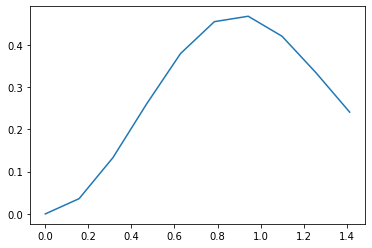

In [9]:
circuit = qiskit.QuantumCircuit(num_sites)
# vacuum
for iq in range(1, num_sites, 2):
    circuit.x(iq)

num_steps = 10
dt = np.pi / 2. / num_steps
density = np.empty(num_steps, dtype=np.float)
for istep in range(num_steps):
    density[istep] = get_density(circuit)
    circuit += one_step(dt)
    
plt.plot(np.arange(0., np.pi / 2, np.pi / 2 / num_steps), density)